#Spam Detection
This project focuses on building and comparing machine learning models for detecting spam messages in text data. The dataset is preprocessed using TF-IDF vectorization to convert text messages into numerical vectors.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [37]:
df = pd.read_csv('sample_data/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


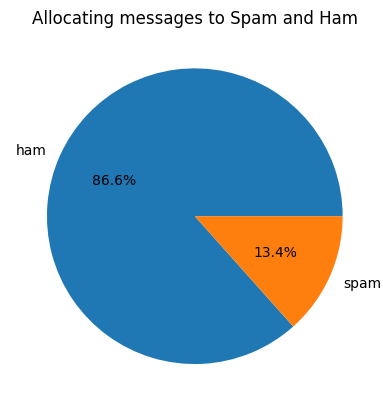

In [38]:
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Allocating messages to Spam and Ham')
plt.ylabel('')
plt.show()

In [39]:
print("Missing values:")
df.isnull().sum()

Missing values:


,0
label,0
message,0


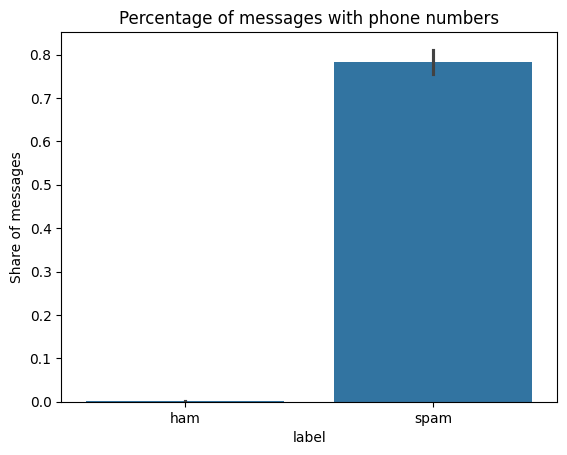

In [40]:
# availability of telephone numbers
df['has_number'] = df['message'].str.contains(r'\d{5,}')

sns.barplot(x='label', y='has_number', data=df)
plt.title('Percentage of messages with phone numbers')
plt.ylabel('Share of messages')
plt.show()



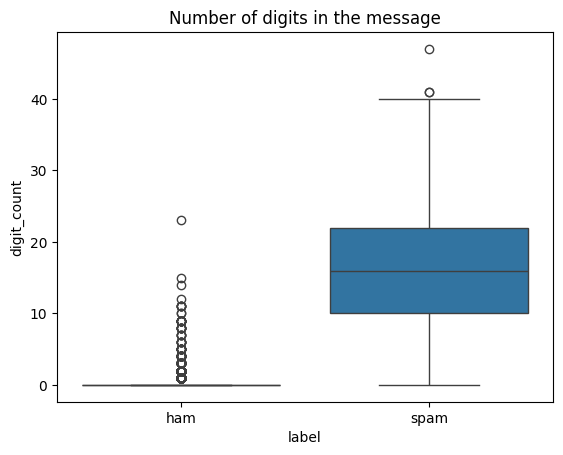

In [41]:
# Number of digits in the message
df['digit_count'] = df['message'].apply(lambda x: sum(c.isdigit() for c in x))

# Visualisation of the number of digits
sns.boxplot(x='label', y='digit_count', data=df)
plt.title('Number of digits in the message')
plt.show()

In [42]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    """
    A function for cleaning and preprocessing text.
    """

    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenisation (breaking down into words)
    tokens = text.split()

    # Removing stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Merge words back into text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
df['cleaned_message'] = df['message'].apply(preprocess_text)

In [44]:
df.head()

,label,message,has_number,digit_count,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",False,0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,False,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,True,25,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,False,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",False,0,nah dont think goes usf lives around though


In [45]:
# The process below converts the cleaned text messages into numerical vectors using the TF-IDF technique.
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['cleaned_message'])
y = df['label']

In [46]:
# This line splits the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Initialisation of models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC()
}
results = {}

In [48]:
for model_name, model in models.items():
    # Model training
    model.fit(X_train, y_train)

    # Prediction
    y_pred = model.predict(X_test)

    # accuracy
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Saving results
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report
    }

    # Output results for each model
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification report:")
    print(report)


Model: Naive Bayes
Accuracy: 96.77%
Classification report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115


Model: Logistic Regression
Accuracy: 95.70%
Classification report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.97      0.70      0.81       149

    accuracy                           0.96      1115
   macro avg       0.96      0.85      0.89      1115
weighted avg       0.96      0.96      0.95      1115


Model: Support Vector Machine
Accuracy: 97.58%
Classification report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.82     

In [34]:
def predict_message(message):
    """
    A function to predict the type of message (spam or not).
    """
    cleaned_message = preprocess_text(message)
    transformed_message = tfidf_vectorizer.transform([cleaned_message])

    predictions = {}

    for model_name, model_info in results.items():
        prediction = model_info['model'].predict(transformed_message)[0]
        predictions[model_name] = prediction

    return predictions

In [50]:
new_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.",
    "Hey, are we still meeting up for lunch tomorrow?",
    "Urgent! Your account has been compromised. Update your password immediately.",
    "Looking forward to our trip next week!",
    "You've been selected for a free vacation! Call now to claim your prize."
]


print("\nPredictions for new messages:")
for message in new_messages:
    print(f"\nMessages: {message}")
    prediction_results = predict_message(message)
    for model_name, prediction in prediction_results.items():
        print(f"{model_name}: {prediction}")



Predictions for new messages:

Messages: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize.
Naive Bayes: spam
Logistic Regression: ham
Support Vector Machine: spam

Messages: Hey, are we still meeting up for lunch tomorrow?
Naive Bayes: ham
Logistic Regression: ham
Support Vector Machine: ham

Messages: Urgent! Your account has been compromised. Update your password immediately.
Naive Bayes: spam
Logistic Regression: ham
Support Vector Machine: ham

Messages: Looking forward to our trip next week!
Naive Bayes: ham
Logistic Regression: ham
Support Vector Machine: ham

Messages: You've been selected for a free vacation! Call now to claim your prize.
Naive Bayes: spam
Logistic Regression: spam
Support Vector Machine: spam


#Conclusion

Naive Bayes and SVM demonstrate strong spam detection capabilities, while Logistic Regression struggles with overlap between spam and legitimate messages. Improving feature representation and combining models could yield better performance.